In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import opendatasets as od
import pandas as pd
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2023-10-30 16:16:40.912255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 16:16:40.954189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 16:16:40.954218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 16:16:40.954244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 16:16:40.961598: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 16:16:40.962765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
od.download("https://www.kaggle.com/datasets/gonzajl/riones-cyst-stone-tumor-normal-dataset")

Skipping, found downloaded files in "./riones-cyst-stone-tumor-normal-dataset" (use force=True to force download)


In [3]:
datos = pd.read_csv('riones-cyst-stone-tumor-normal-dataset/dataset/datos.csv')

In [4]:
datos

,imagen,cyst,stone,tumor,normal
0,dataset/tumor/kidney-tumor-2706.jpg,0,0,1,0
1,dataset/stone/kidney-stone-0729.png,0,1,0,0
2,dataset/tumor/kidney-tumor-2166.jpg,0,0,1,0
3,dataset/normal/kidney-normal-2626.jpg,0,0,0,1
4,dataset/stone/kidney-stone-0879.png,0,1,0,0
...,...,...,...,...,...
11751,dataset/cyst/kidney-cyst-2616.jpg,1,0,0,0
11752,dataset/tumor/kidney-tumor-0810.jpg,0,0,1,0
11753,dataset/cyst/kidney-cyst-2314.jpg,1,0,0,0
11754,dataset/normal/kidney-normal-2521.jpg,0,0,0,1


In [5]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'riones-cyst-stone-tumor-normal-dataset/' + nombres[i]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        imagen = imagen.reshape(imagen.shape[0], imagen.shape[0], 1)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))

    return imagenes, etiquetas

In [6]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]   #ignoro filas particulares y traigo las columnas de 1 a fin

In [7]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [8]:
def mostrar_grafico_clases(etiquetas):
    cyst = etiquetas.count([1, 0, 0, 0])
    stone = etiquetas.count([0, 1, 0, 0])
    tumor = etiquetas.count([0, 0, 1, 0])
    normal = etiquetas.count([0, 0, 0, 1])

    categorias = ['cyst', 'stone', 'tumor', 'normal']
    cantidades = [cyst, stone, tumor, normal]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Cantidad de Imágenes por Clase')

    plt.show()

In [9]:
div_test = int(len(imagenes) * 0.8)

In [10]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

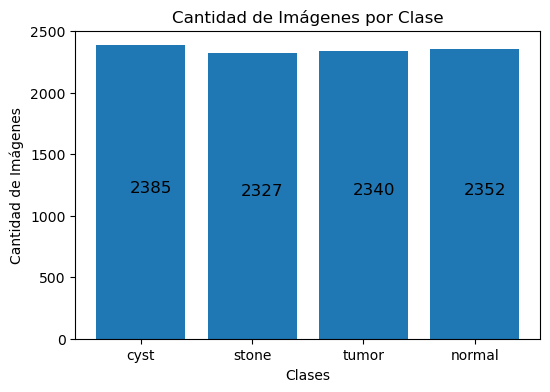

In [11]:
mostrar_grafico_clases(etiquetas_entrenamiento)

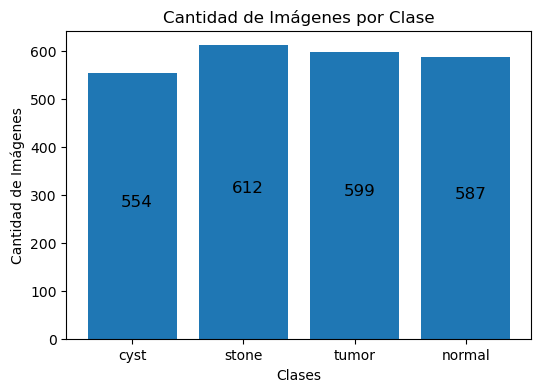

In [12]:
mostrar_grafico_clases(etiquetas_prueba)

In [13]:
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

forma_etiqueta = etiquetas_entrenamiento[0].shape #Esto muestra el formato actual de las etiquetas, en particular muestra la primera
                                                    #del array de entrenamiento
print(forma_etiqueta)

(4,)


In [14]:
print(etiquetas_entrenamiento.shape)

(9404, 4)


In [15]:
modelo_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [16]:
modelo_cnn.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy'])

In [17]:
vueltas=25

In [18]:
historial_cnn = modelo_cnn.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=vueltas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)

Epoch 1/25
294/294 [==============================] - 64s 215ms/step - loss: 0.4769 - categorical_accuracy: 0.8055 - val_loss: 0.1371 - val_categorical_accuracy: 0.9392
Epoch 2/25
294/294 [==============================] - 62s 210ms/step - loss: 0.1253 - categorical_accuracy: 0.9469 - val_loss: 0.0813 - val_categorical_accuracy: 0.9575
Epoch 3/25
294/294 [==============================] - 62s 211ms/step - loss: 0.0699 - categorical_accuracy: 0.9756 - val_loss: 0.0574 - val_categorical_accuracy: 0.9813
Epoch 4/25
294/294 [==============================] - 61s 208ms/step - loss: 0.0450 - categorical_accuracy: 0.9844 - val_loss: 0.0425 - val_categorical_accuracy: 0.9826
Epoch 5/25
294/294 [==============================] - 62s 210ms/step - loss: 0.0270 - categorical_accuracy: 0.9919 - val_loss: 0.0344 - val_categorical_accuracy: 0.9898
Epoch 6/25
294/294 [==============================] - 62s 210ms/step - loss: 0.0245 - categorical_accuracy: 0.9927 - val_loss: 0.0256 - val_categorical_acc

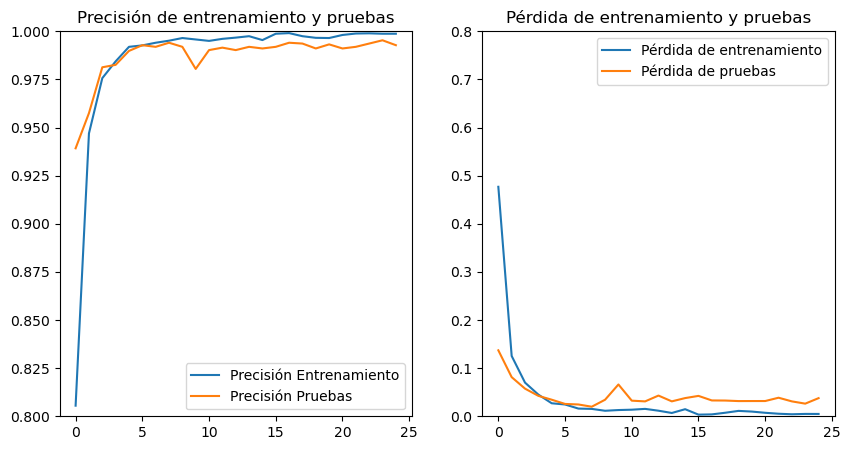

In [19]:
# Graficas de precisión y pérdida del modelo
categorical_accuracy = historial_cnn.history['categorical_accuracy']
val_categorical_accuracy = historial_cnn.history['val_categorical_accuracy']

loss = historial_cnn.history['loss']
val_loss = historial_cnn.history['val_loss']

rango_epocas = range(vueltas)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, categorical_accuracy, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_categorical_accuracy, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 0.8)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [20]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [21]:
correctas_segun_tipo = [0, 0, 0, 0]
falladas_segun_tipo = [0, 0, 0, 0]

predicciones = modelo_cnn.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))

    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1
    else:
        falladas_segun_tipo[index] += 1

cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [C, S, T, N]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

74/74 [==============================] - 4s 58ms/step
Cantidad de predicciones: 2352
Etiquetas:   [C, S, T, N]
Total:       [558, 606, 596, 592]
Correctas:   [554, 602, 596, 583]
Incorrectas: [4, 4, 0, 9]


In [22]:
modelo_cnn.save('cnn-riñones.h5')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
